In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib

Using matplotlib backend: TkAgg


In [10]:
# 加载训练集和测试集的数据
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [11]:
train.drop(train[(train.GrLivArea>4000)&(train.SalePrice<300000)].index, inplace=True)

In [12]:
train.drop(train[(train.TotalBsmtSF>3000)&(train.SalePrice<300000)].index, inplace=True)

In [13]:
# 拼接训练集和测试集数据，并删除Id,SalePrice
full = pd.concat([train,test],ignore_index=True)
full.drop(['Id','SalePrice'],axis=1,inplace=True)

In [14]:
full['LotFrontage'] = np.sqrt(full['LotArea'])
train['LotFrontage'] = np.sqrt(full['LotArea'])

In [15]:
# 查看缺失值
# PoolQC, MiscFeature,Alley,Fence,FireplaceQU缺失率大于50%，去掉
#Garage系列,缺失的情况类似，估计是同一种手段采集的数据，另外关于Garage的信息已经由，GarageCar表达，所以这些可以删去
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1451,0.995882
MiscFeature,1403,0.962938
Alley,1366,0.937543
Fence,1176,0.807138
FireplaceQu,690,0.473576
GarageCond,81,0.055594
GarageType,81,0.055594
GarageYrBlt,81,0.055594
GarageFinish,81,0.055594
GarageQual,81,0.055594


In [16]:
# 删除上面的列
full = full.drop((missing_data[missing_data['Total']>1]).index,1)

In [17]:
tmp = full.isnull().sum()
tmp[tmp>0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtFullBath    2
BsmtHalfBath    2
BsmtUnfSF       1
Electrical      1
Exterior1st     1
Exterior2nd     1
Functional      2
GarageArea      1
GarageCars      1
KitchenQual     1
MSZoning        4
SaleType        1
TotalBsmtSF     1
Utilities       2
dtype: int64

In [18]:
for col in tmp[tmp>0].index:
    if full[col].dtype == np.object:
        full[col].fillna('None',inplace=True)
    else:
        full[col].fillna(0,inplace=True)

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
full['YearBuilt'] = LabelEncoder().fit_transform(full.YearBuilt)

In [21]:
full = pd.get_dummies(full)

In [22]:
from sklearn.preprocessing import StandardScaler,RobustScaler

In [23]:
full = RobustScaler().fit_transform(full)

In [78]:
train_len = len(train)
train_x = full[:train_len]
test_x = full[train_len:]
y = np.log(train.SalePrice)

# 模型融合

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# 将数据顺序打乱
train_x,y = shuffle(train_x,y)
# 切分数据集进行2，8分
X_train,X_val,y_train,y_val = train_test_split(train_x, y, test_size=0.2,random_state=123)

# 基础的线性回归

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [82]:
def benchmark(model):
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,pred))
    return rmse

In [119]:
lr = LinearRegression()

In [120]:
lr.fit(train_x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
benchmark(lr)

0.0958122656082243

# Ridge Regression

In [122]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV

In [123]:
kfolds = KFold(n_splits=10,shuffle=True,random_state=123)

In [124]:
alphas = [0.0001,0.0003,0.0005, 0.0009,
          0.01,0.03,0.05, 0.09,
          0.1,0.3,0.9,
          1,3,5,7,9,
          10,20,30,40,60,70,80,90]
rcv = RidgeCV(alphas=alphas,cv=kfolds)
rcv.fit(train_x,y)

RidgeCV(alphas=array([1.e-04, 3.e-04, 5.e-04, 9.e-04, 1.e-02, 3.e-02, 5.e-02, 9.e-02,
       1.e-01, 3.e-01, 9.e-01, 1.e+00, 3.e+00, 5.e+00, 7.e+00, 9.e+00,
       1.e+01, 2.e+01, 3.e+01, 4.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01]),
        cv=KFold(n_splits=10, random_state=123, shuffle=True),
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [125]:
benchmark(rcv)

0.09951844185723004

In [126]:
def ridge_train_test(alpha):
    rcv = RidgeCV(alphas=[alpha],cv=kfolds)
    rcv.fit(X_train,y_train)
    pred = rcv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,pred))
    return rmse

In [127]:
scores = []
for i in alphas:
    scores.append(ridge_train_test(i))

In [128]:
scores

[0.13394904135514646,
 0.13393842713206827,
 0.13392783471176323,
 0.1339067149255121,
 0.13344823003858144,
 0.13256428768112696,
 0.13180933061049388,
 0.13056315548041716,
 0.13029238929044143,
 0.1265824750681052,
 0.12143114367392087,
 0.12088237771092117,
 0.11526503969878181,
 0.11323897908187604,
 0.1122830414400504,
 0.11178177799159852,
 0.11162489956501205,
 0.11131983046599894,
 0.11169467159118728,
 0.11222445203666503,
 0.11341382318502011,
 0.11402595972676127,
 0.11463772987990066,
 0.11524522013084197]

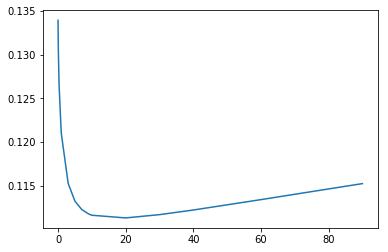

In [130]:
plt.plot(alphas,scores)

In [131]:
scores = []
for i in np.linspace(30,40,100):
    scores.append(ridge_train_test(i))

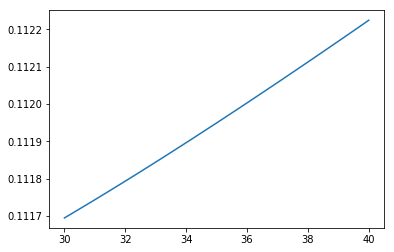

In [132]:
plt.plot(np.linspace(30,40,100),scores)

In [133]:
# alpha 取33

In [134]:
rcv = RidgeCV(alphas=[43],cv=kfolds)
rcv.fit(X_train,y_train)
pred = rcv.predict(X_val)
print(np.sqrt(mean_squared_error(pred,y_val)))
print(rcv.alpha_)

0.11239607244522305
43


In [135]:
rcv = RidgeCV(alphas=np.logspace(-10,2,100),cv=kfolds)
rcv.fit(X_train,y_train)
pred = rcv.predict(X_val)
print(np.sqrt(mean_squared_error(pred,y_val)))

0.11196718925907366


In [136]:
rcv.alpha_

8.11130830789689

# Lasso Regression

In [99]:
from sklearn.linear_model import LassoCV

In [100]:
alphas2 = [0.00005,0.0001,0.0002,0.0005,0.0006,0.0007,0.0008,0.0009]

In [137]:
lcv = LassoCV(alphas=alphas2, random_state=123,cv=10).fit(train_x,y)

In [138]:
pred = lcv.predict(X_val)
print(np.sqrt(mean_squared_error(pred,y_val)))

0.10150587209433103


# Elastic Net

In [103]:
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline( 
                           ElasticNetCV( alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

In [139]:
elastic_model3=elastic_cv.fit(train_x,y)

In [140]:
pred = elastic_model3.predict(X_val)
print(np.sqrt(mean_squared_error(pred,y_val)))

0.10051051487118841


# xgboost

In [106]:
import xgboost as xgb

In [107]:
#XGBoost

xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3460,subsample=0.7,reg_alpha=0.00006,gamma=0,nthread=6,scale_pos_weight=1,seed=27)


In [141]:
xg_reg.fit(train_x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.7, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=3460, n_jobs=1,
             nthread=6, objective='reg:linear', random_state=0, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
             subsample=0.7)

In [142]:
pred = xg_reg.predict(X_val)
print(np.sqrt(mean_squared_error(pred,y_val)))

0.055281179371999986


# 决策树

In [145]:
from sklearn.tree import DecisionTreeRegressor

In [146]:
dtr = DecisionTreeRegressor()

In [147]:
dtr.fit(train_x,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [151]:
pred = dtr.predict(X_val)
print('{:.6f}'.format(np.sqrt(mean_squared_error(pred,y_val))))

0.000035


In [183]:
from sklearn.ensemble import GradientBoostingRegressor

In [184]:
gbr = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05)

In [185]:
gbr.fit(train_x,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [186]:
benchmark(gbr)

0.014409573790840444

In [155]:
from mlxtend.regressor import StackingCVRegressor

In [198]:
stack_gen = StackingCVRegressor(regressors=(rcv,lcv,xg_reg,gbr),
                               meta_regressor=xg_reg,
                               use_features_in_secondary=True)

In [199]:
stack_gen.fit(train_x,y)

StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bytree=0.7, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.01,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=3460,
                                                n_jobs=1, nthread=6,
                                                objective='reg:linear',
                                                random_state=0, reg_alpha=6e-05,
                                                reg_lambda=1,
                                            

In [203]:
pred  = stack_gen.predict(test_x)

In [201]:
pred = np.exp(pred)

In [202]:
result = pd.DataFrame({'Id':test.Id,'SalePrice':pred})
result.to_csv('submission.csv',index=False)

In [205]:
benchmark(stack_gen)

0.046664532425945905